In [374]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score, mean_absolute_error

In [375]:
data = pd.read_excel('data/data.xlsx')

In [376]:
data.head()

,program,men students,women students,men professors,women professors,professors/doctorate,professors/masters,professors/bachelors,titular professors,associate professors,professor assistants,plant professors,instructor professors,emeritus professors,visitant professors
0,Administración,707,495,105,50,55,10,0,4.0,25.5,27.0,0,1,1,0.5
1,Arquitectura,334,388,58,30,10,16,1,2.5,14.5,9.0,0,0,0,0.0
2,Diseño,191,642,40,41,7,23,1,0.0,17.5,13.0,0,0,0,0.0
3,Arquitectura y Diseño,525,103,99,71,17,40,2,3.5,32.0,22.0,0,0,0,0.0
4,Arte,57,147,27,24,0,17,0,1.0,11.0,5.0,0,0,0,0.0


## Random Forests

In [377]:
predictors = list(data.keys())
predictors.remove('program')
predictors.remove('women students')
print(predictors, np.shape(np.array(predictors)))

['men students', 'men professors', 'women professors', 'professors/doctorate', 'professors/masters', 'professors/bachelors', 'titular professors', 'associate professors', 'professor assistants', 'plant professors', 'instructor professors', 'emeritus professors', 'visitant professors'] (13,)


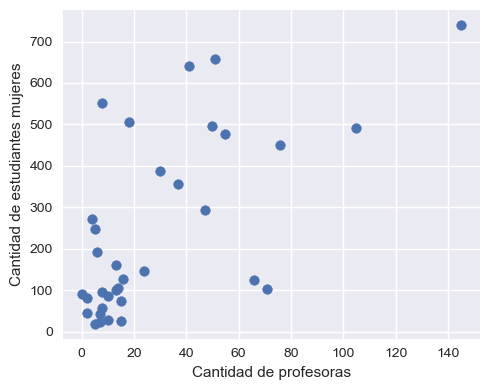

In [389]:
plt.figure(figsize = (5, 4), dpi = 100)
plt.scatter(data['women professors'], data['women students'])
plt.xlabel('Cantidad de profesoras')
plt.ylabel('Cantidad de estudiantes mujeres')
plt.tight_layout()
plt.savefig('results/data.png')

In [378]:
import sklearn.model_selection

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
                                    data[predictors], data['women students'], test_size = 0.5)

In [379]:
import sklearn.ensemble

rf = sklearn.ensemble.RandomForestRegressor(n_estimators = 10)
rf.fit(X_train, y_train)
_ = rf.estimators_

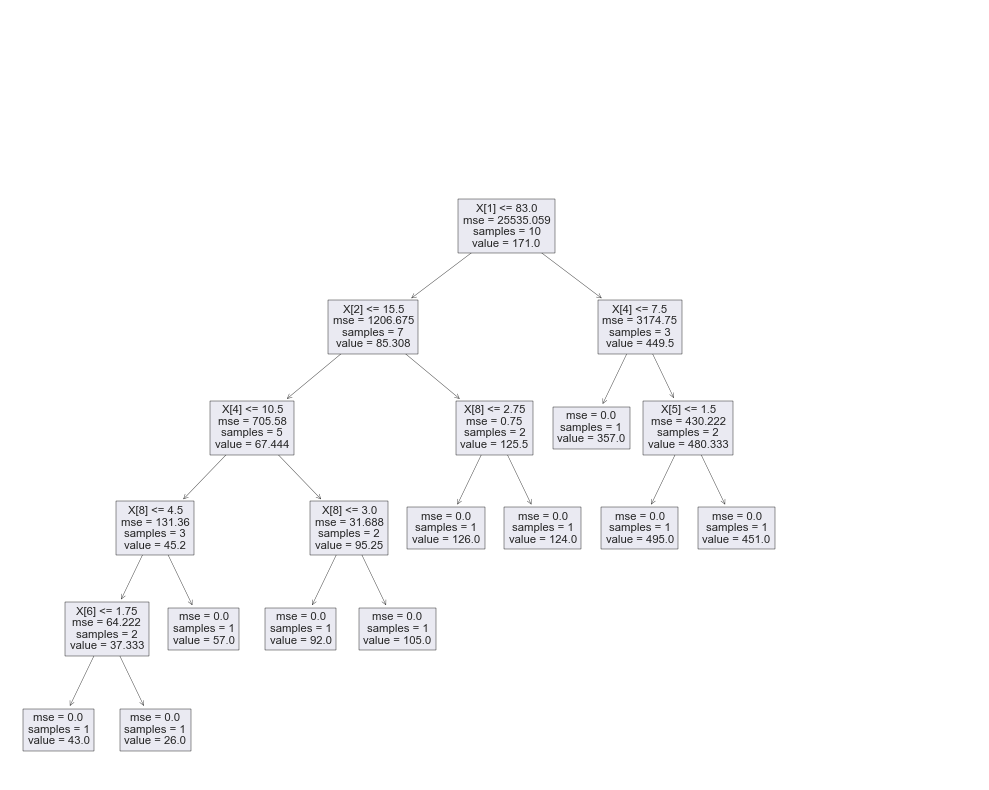

In [380]:
plt.figure(figsize=(10, 8), dpi = 100)
_= sklearn.tree.plot_tree(rf.estimators_[5])
plt.tight_layout()
plt.savefig('results/tree.png')

In [381]:
rf.predict(X_test)

array([587.7, 439.4,  43. , 261.1, 141.1, 300.4,  67.6,  56.6, 336.3,
        46. , 206.9,  94.6, 177. ,  50. , 111.9,  48.4, 327.3])

In [382]:
n_trees = np.arange(1, 20, 1)
mse_train = []
mse_test = []
feature_importance = np.zeros((len(n_trees), len(predictors)))

for i, n_tree in enumerate(n_trees):
    clf = sklearn.ensemble.RandomForestRegressor(n_estimators = n_tree, max_features = 'sqrt')
    clf.fit(X_train, y_train)
    mse_train.append(mse(y_train, clf.predict(X_train))/100000)
    mse_test.append(mse(y_test, clf.predict(X_test))/100000)
    feature_importance[i, :] = clf.feature_importances_

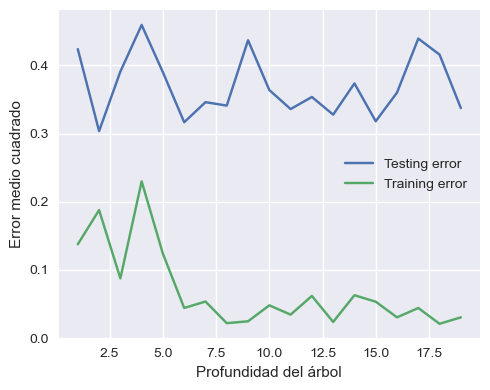

In [383]:
plt.style.use('seaborn')

plt.figure(figsize = (5, 4), dpi = 100)
plt.plot(n_trees, mse_test, label = 'Testing error')
plt.plot(n_trees, mse_train, label = 'Training error')
plt.xlabel('Profundidad del árbol')
plt.ylabel('Error medio cuadrado')
# plt.axvline(x = 5, color='orange', linestyle='--')
_ = plt.legend()
plt.tight_layout()
plt.savefig('results/error.png')

men students             0.110345
men professors           0.139276
women professors         0.239065
professors/doctorate     0.087986
professors/masters       0.050079
professors/bachelors     0.029413
titular professors       0.045629
associate professors     0.129312
professor assistants     0.087268
plant professors         0.035533
instructor professors    0.021254
emeritus professors      0.019948
visitant professors      0.004891
dtype: float64


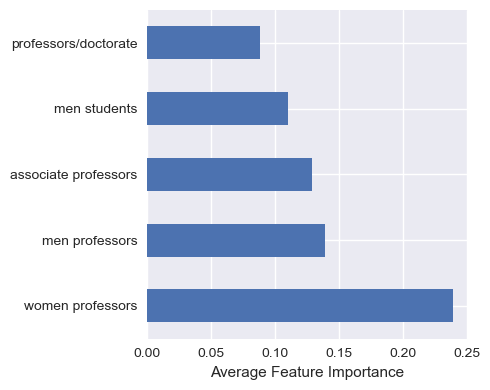

In [393]:
avg_importance = np.average(feature_importance, axis = 0)
a = pd.Series(avg_importance, index  = predictors)
print(a)
plt.figure(figsize = (5, 4), dpi = 100)
a.nlargest().plot(kind = 'barh')
plt.xlabel('Average Feature Importance')
plt.tight_layout()
plt.savefig('results/importances.png')

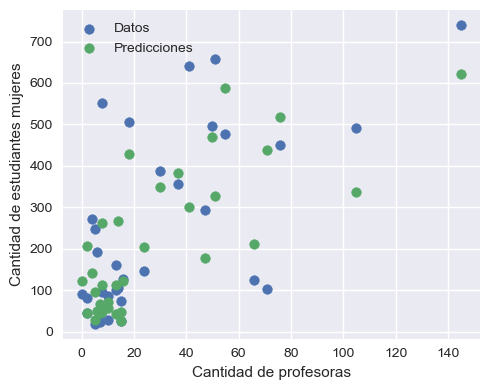

In [394]:
plt.figure(figsize = (5, 4), dpi = 100)
plt.scatter(data['women professors'], data['women students'], label = 'Datos')
plt.scatter(data['women professors'], rf.predict(data[predictors]), label = 'Predicciones')
plt.xlabel('Cantidad de profesoras')
plt.ylabel('Cantidad de estudiantes mujeres')
plt.legend()
plt.tight_layout()
plt.savefig('results/predictions.png')

In [399]:
mae = mean_absolute_error(data['women students'].ravel(), rf.predict(data[predictors]))
mse = mse(data['women students'].ravel(), rf.predict(data[predictors]))
r2 = r2_score(data['women students'].ravel(), rf.predict(data[predictors]))

print('Mean Absolute Error:', round(mae, 2))
print('Mean Squared Error:', round(mse, 2))
print('R-Squared Scores:', round(r2, 2))

Mean Absolute Error: 94.45
Mean Squared Error: 18637.06
R-Squared Scores: 0.59
